## To-do List

1) keras로 Deep Autoencoder
(same as in DEC) --> DEC 관련 논문 3개는 읽어봐야 할듯.

**hyperparameter**
- d-500-500-2000-10-2000-500-500-d (deep autoencoder)
- activation : ReLU
- epochs : 50
- minibatch size : 256


2) sklearn으로 Spectral Clustering
- K-NN Graph에서 K는 5로 고정되어있다. (fashion-MNIST, 20newsgroup)

In [1]:
from time import time
import os
import pickle

import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups
#from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import pairwise_distances

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

### fashion-mnist load 

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

y_train = y_train.astype("float32") / 255.
y_test = y_test.astype("float32") / 255.

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


### 20newsgroup load 

In [4]:
dataset = fetch_20newsgroups(subset='all')
X = dataset.data
Y = dataset.target


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,
                                                   random_state=42)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

vectorizer = TfidfVectorizer(max_features=2000)

tfidf_X_train = vectorizer.fit_transform(X_train).toarray()
tfidf_X_test = vectorizer.fit_transform(X_test).toarray()
print(tfidf_X_train.shape)
print(tfidf_X_test.shape)

14134
4712
14134
4712
(14134, 2000)
(4712, 2000)


### Autoencoder for fashion-mnist 

In [5]:
class Autoencoder(Model):
    def __init__(self, dim1, dim2, dim3, latent_dim):
        super(Autoencoder, self).__init__()
        #super().__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28)),
            Flatten(),
            Dense(dim1, activation='relu'), #500
            Dense(dim2, activation='relu'), #500
            Dense(dim3, activation='relu'), #2000
            Dense(latent_dim) # 10
        ])
        self.decoder = tf.keras.Sequential([
            Dense(dim3, activation='relu'), # 2000
            Dense(dim2, activation='relu'), # 500
            Dense(dim1, activation='relu'), # 500
            Dense(784), # d
            Reshape((28, 28))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Autoencoder for 20newsgroup 

In [6]:
class Autoencoder2(Model):
    def __init__(self, dim1, dim2, dim3, latent_dim):
        super(Autoencoder2, self).__init__()
        #super().__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            Input(shape=(2000, )), #d
            Dense(dim1, activation='relu'), #500
            Dense(dim2, activation='relu'), #500
            Dense(dim3, activation='relu'), #2000
            Dense(latent_dim) # 10
        ])
        self.decoder = tf.keras.Sequential([
            Dense(dim3, activation='relu'), # 2000
            Dense(dim2, activation='relu'), # 500
            Dense(dim1, activation='relu'), # 500
            Dense(2000), # d
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
autoencoder = Autoencoder(500, 500, 2000, 10)
autoencoder.compile(optimizer='sgd', loss=MeanSquaredError())

In [8]:
epochs = 50
batch_size = 256

if os.path.exists(f"model/fashion-mnist_AE_model({epochs}epochs).h5"):
    autoencoder.fit(x_train, x_train,
                                epochs=1,
                                shuffle=True,
                                batch_size=batch_size,
                                verbose=0,
                                validation_data=(x_test, x_test))
    autoencoder.load_weights(f"model/fashion-mnist_AE_model({epochs}epochs).h5")
    start = 0.0
    end = 0.0

else:
    start = time()
#     autoencoder = Autoencoder(500, 500, 2000, 10)
#     autoencoder.compile(optimizer='sgd', loss=MeanSquaredError())
    mnist_history = autoencoder.fit(x_train, x_train,
                                epochs=epochs,
                                shuffle=True,
                                batch_size=batch_size,
                                verbose=2,
                                validation_data=(x_test, x_test))

    end = time()

    autoencoder.save_weights(f"model/fashion-mnist_AE_model({epochs}epochs).h5")

In [9]:
print("Elapsed Time for Training Deep Autoencoder : %.3f sec." % (end - start)) 

Elapsed Time for Training Deep Autoencoder : 0.000 sec.


### Visualized decoded images 

In [10]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

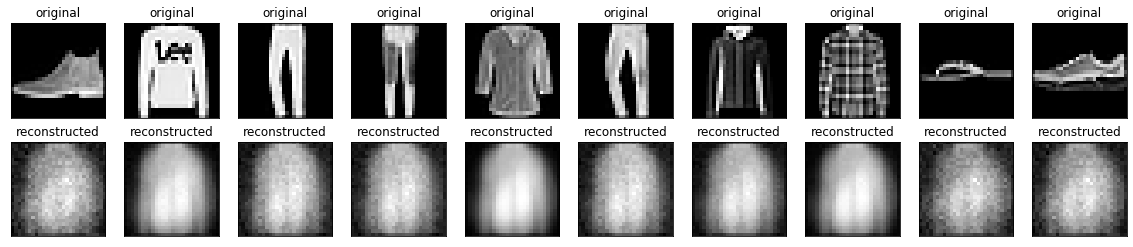

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### fashion-mnist Spectral Clustering 

In [12]:
K = 5
n_clusters = 10

x = np.concatenate([x_train, x_test]) # 70000 imgs
y = np.concatenate([y_train, y_test]) # 70000 labels

Z = autoencoder.encoder(x).numpy() # latent features (10dim)
print("Latent features are set.\n")

# if os.path.exists(file_name):
#     with open(file_name, "rb") as f:
#         L = np.load(f)

# else:
#     L = pairwise_distances(Z, n_jobs=16) # affinity matrix
#     with open(file_name, "wb") as f:
#         np.save(f, L)
    
#print("Normalized Laplacian Matrix is set.\n\n")

print("Start Spectral Embedding\n")
start_sc = time()
se_model = SpectralEmbedding(n_components=K, n_neighbors=n_clusters, eigen_solver='amg', n_jobs=-1)
se_vec = se_model.fit_transform(Z)
#se_vec = normalize(se_vec, norm='l2')
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=-1).fit(se_vec)
y_pred = kmeans.labels_
end_sc = time()

print("ARI : %.3f" % adjusted_rand_score(y, y_pred))
print("NMI : %.3f" % normalized_mutual_info_score(y, y_pred))
print("Elasped Time for %.3f" % (end_sc - start_sc))

Latent features are set.

Start Spectral Embedding

ARI : 0.162
NMI : 0.280
Elasped Time for 5.320


### 20newsgroup training 

In [13]:
autoencoder2 = Autoencoder2(500, 500, 2000, 10)
autoencoder2.compile(optimizer='sgd', loss=MeanSquaredError())

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

epochs = 50
batch_size = 256

if os.path.exists(f"model/newsgroup_AE_model({epochs}epochs).h5"):
    autoencoder2.fit(tfidf_X_train, tfidf_X_train,
                                epochs=1,
                                shuffle=True,
                                batch_size=batch_size,
                                verbose=2,
                                validation_data=(tfidf_X_test, tfidf_X_test))
    autoencoder2.load_weights(f"model/newsgroup_AE_model({epochs}epochs).h5")
    start = end = 0.0

else:
    start = time()
    news_history = autoencoder2.fit(tfidf_X_train, tfidf_X_train,
                                epochs=epochs,
                                shuffle=True,
                                batch_size=batch_size,
                                verbose=2,
                                validation_data=(tfidf_X_test, tfidf_X_test))

    end = time()
    autoencoder2.save_weights(f"model/newsgroup_AE_model({epochs}epochs).h5")

Train on 14134 samples, validate on 4712 samples
Epoch 1/50
14134/14134 - 1s - loss: 5.0012e-04 - val_loss: 5.0003e-04
Epoch 2/50
14134/14134 - 0s - loss: 5.0003e-04 - val_loss: 5.0001e-04
Epoch 3/50
14134/14134 - 0s - loss: 4.9994e-04 - val_loss: 4.9999e-04
Epoch 4/50
14134/14134 - 0s - loss: 4.9986e-04 - val_loss: 4.9996e-04
Epoch 5/50
14134/14134 - 0s - loss: 4.9977e-04 - val_loss: 4.9994e-04
Epoch 6/50
14134/14134 - 0s - loss: 4.9968e-04 - val_loss: 4.9992e-04
Epoch 7/50
14134/14134 - 0s - loss: 4.9960e-04 - val_loss: 4.9990e-04
Epoch 8/50
14134/14134 - 0s - loss: 4.9951e-04 - val_loss: 4.9987e-04
Epoch 9/50
14134/14134 - 0s - loss: 4.9943e-04 - val_loss: 4.9985e-04
Epoch 10/50
14134/14134 - 0s - loss: 4.9934e-04 - val_loss: 4.9983e-04
Epoch 11/50
14134/14134 - 0s - loss: 4.9925e-04 - val_loss: 4.9981e-04
Epoch 12/50
14134/14134 - 0s - loss: 4.9917e-04 - val_loss: 4.9978e-04
Epoch 13/50
14134/14134 - 0s - loss: 4.9908e-04 - val_loss: 4.9976e-04
Epoch 14/50
14134/14134 - 0s - loss: 

In [15]:
print("Elapsed Time for Training Deep Autoencoder : %.3f sec." % (end - start))

Elapsed Time for Training Deep Autoencoder : 15.589 sec.


### 20newsgroup Spectral clustering 

In [16]:
K = 5
n_clusters = 20
#file_name2 = "20news_matrix(L2).npy"
file_name2 = "data/20news_tfidfVec.pk"

if os.path.exists(file_name2):
    with open(file_name2, "rb") as f:
        tfidf_X = pickle.load(f)

else:
    tfidf_X = vectorizer.fit_transform(X)
    
    with open(file_name2, "wb") as f:
        pickle.dump(tfidf_X, f)
    
print("Tfidf Matrix is set.\n\n")

print("Start Spectral Clustering\n")
start_sc = time()
#se_model2 = SpectralEmbedding(n_components=K, n_neighbors=n_clusters, eigen_solver='amg', n_jobs=-1)
se_model2 = SpectralEmbedding(n_components=K, affinity='rbf', n_jobs=-1)
se_vec2 = se_model2.fit_transform(tfidf_X)
#se_vec2 = normalize(se_vec2, norm='l2')
kmeans2 = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=-1).fit(se_vec2)
Y_pred = kmeans2.labels_
end_sc = time()

print("End Spectral Clustering\n")

print("ARI : %.3f" % adjusted_rand_score(Y, Y_pred))
print("NMI : %.3f" % normalized_mutual_info_score(Y, Y_pred))
print("Elapsed Time for SC : %.3f" % (end_sc - start_sc))

Tfidf Matrix is set.


Start Spectral Clustering

End Spectral Clustering

ARI : 0.067
NMI : 0.187
Elapsed Time for SC : 45.132
